Company XYZ sells a software for \\$39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price (\\$39), while a random sample of 33% users a higher price (\\$59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

Especially, you were asked the following questions:

- Should the company sell its software for \\$39 or \\$59?

- The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

- [Bonus] The VP of Product feels that the test has been running for too long and they should have been able to get statistically significant results in a shorter time. Do you agree with this? After how many days you would have stopped the test? Please, explain why.

In [1]:
import pandas as pd
from scipy import stats
import statsmodels.stats.api as sms
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)

In [6]:
print("User table: ")
user = pd.read_csv("user_table.csv")
print(user.head())
print("------------------------------------------------------------------------------------------------------")
print("Test Results table: ")
test = pd.read_csv("test_results.csv")
print(test.head())

User table: 
   user_id         city country    lat    long
0   510335      Peabody     USA  42.53  -70.97
1    89568         Reno     USA  39.54 -119.82
2   434134       Rialto     USA  34.11 -117.39
3   289769  Carson City     USA  39.15 -119.74
4   939586      Chicago     USA  41.84  -87.68
------------------------------------------------------------------------------------------------------
Test Results table: 
   user_id            timestamp          source  device operative_system  test  price  converted
0   604839  2015-05-08 03:38:34    ads_facebook  mobile              iOS     0     39          0
1   624057  2015-05-10 21:08:46      seo-google  mobile          android     0     39          0
2   317970  2015-04-04 15:01:23        ads-bing  mobile          android     0     39          0
3   685636  2015-05-07 07:26:01  direct_traffic  mobile              iOS     1     59          0
4   820854  2015-05-24 11:04:40    ads_facebook     web              mac     0     39          0

In [11]:
# Check for null values
print(user.isnull().values.any(), test.isnull().values.any())

False False


In [12]:
df = pd.merge(test, user, how='left', on='user_id')
df.head()

,user_id,timestamp,source,device,operative_system,...,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,...,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,...,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,...,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,...,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,...,0,Fishers,USA,39.95,-86.02


In [15]:
# Check if there are users in the test table who are not in the user table
df.isnull().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41184
country             41184
lat                 41184
long                41184
dtype: int64

In [20]:
test.shape[0]- user.shape[0]

41184

In [29]:
df[['test', 'price', 'user_id']].groupby(['test', 'price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

We notice that some users are getting the wrong price in the test/control groups. Let's filter those values.

In [31]:
df = df[((df['test']==0) & (df['price']==39)) | ((df['test']==1) & (df['price']==59))]
df[['user_id','test','price']].groupby(['test','price']).count()

,,user_id
test,price,
0,39,202517
1,59,113918


In [40]:
df['revenue'] = df['converted']*df['price']

print(df.groupby('test')['converted'].mean())
print(df.groupby('test')['revenue'].mean())

test
0    0.019900
1    0.015555
Name: converted, dtype: float64
test
0    0.776083
1    0.917748
Name: revenue, dtype: float64


/tmp/ipykernel_13777/558984852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['revenue'] = df['converted']*df['price']


Conversion rate went down (0.015555-0.019900/0.019900 = approximately 22%) but revenue is up.

In [43]:
test = stats.ttest_ind(df.loc[df['test'] == 1]['revenue'],
                      df.loc[df['test'] == 0]['revenue'],
                      equal_var=False)
# equal_varbool, optional.If True (default), perform a standard independent 2 sample test that assumes equal 
# population variances [1]. If False, perform Welch’s t-test, which does not assume equal population variance 
print(test.statistic, test.pvalue)

5.715224666463108 1.0972577312420781e-08


In [44]:
#print test results
if (test.pvalue>0.05):
  print ("Non-significant results")
elif (test.statistic>0):
  print ("Statistically better results")
else:
  print ("Statistically worse results")

Statistically better results


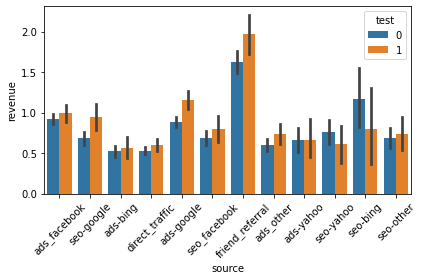

In [56]:
sns.barplot(x='source', y='revenue', hue='test', data=df)
plt.xticks(rotation=45)

plt.show()

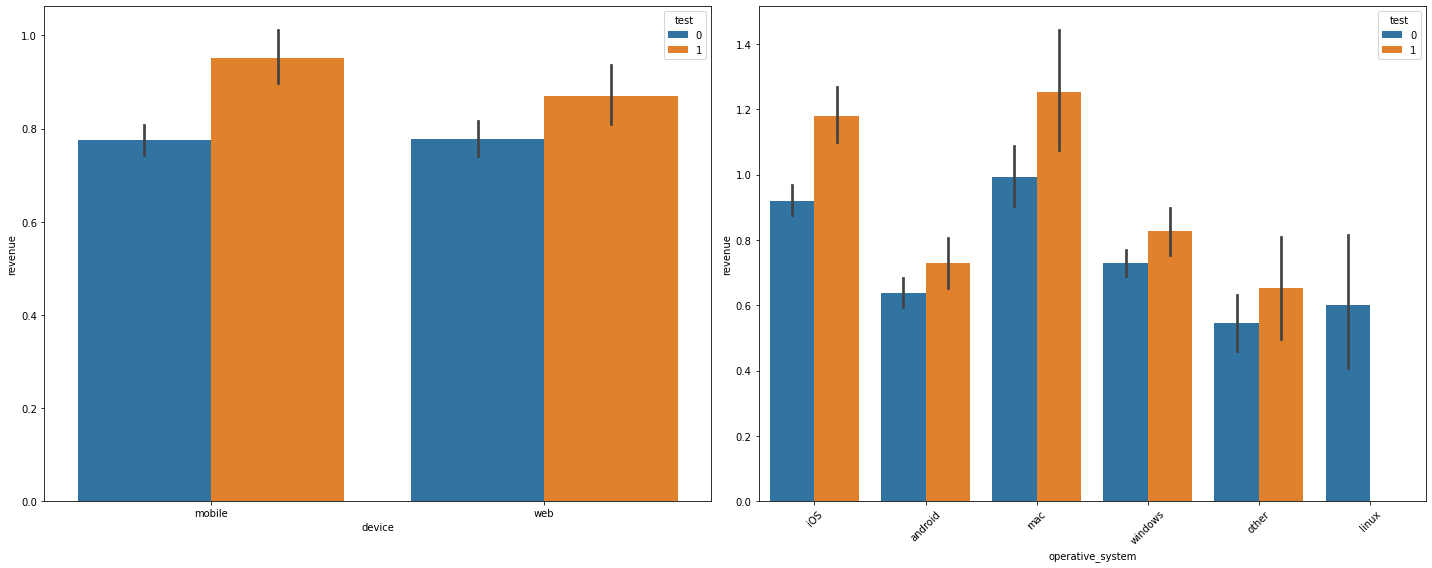

In [57]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))

sns.barplot(x='device', y='revenue', hue='test', data=df, ax=ax1)
sns.barplot(x='operative_system',y='revenue', hue='test', data=df, ax=ax2)

plt.xticks(rotation=45)

plt.show()

It seems that Limux has no conversion rate on test, which is likely a bug

In [74]:
df_linux = df.loc[df['operative_system'] == 'linux']
df_linux.shape[0] / df.shape[0]

0.01305165357814401

In [75]:
df_not_linux = df.loc[df['operative_system'] != 'linux']
test = stats.ttest_ind(df_not_linux.loc[df_not_linux['test'] == 1]['revenue'],
                      df_not_linux.loc[df_not_linux['test'] == 0]['revenue'],
                      equal_var=False)
test

Ttest_indResult(statistic=6.184240028400434, pvalue=6.253458285742887e-10)

Overall numbers seem to have improved slightly

In [101]:
top_cities = df_not_linux['city'].value_counts().sort_values(ascending=False).head(10).reset_index()
top_cities

,city,count
0,New York,25401
1,Chicago,7071
2,Houston,6608
3,San Antonio,4554
4,Los Angeles,4089
5,San Jose,3312
6,Indianapolis,3177
7,Jacksonville,2865
8,Philadelphia,2488
9,Las Vegas,2375


In [103]:
df_top_cities = df_not_linux.loc[df_not_linux['city'].isin(top_cities['city'])]

In [104]:
df_top_cities

,user_id,timestamp,source,device,operative_system,...,city,country,lat,long,revenue
5,169971,2015-04-13 12:07:08,ads-google,mobile,iOS,...,New York,USA,40.67,-73.94,0
18,599771,2015-03-28 18:41:37,direct_traffic,mobile,iOS,...,Chicago,USA,41.84,-87.68,0
20,747762,2015-04-04 23:10:20,ads_facebook,mobile,iOS,...,New York,USA,40.67,-73.94,0
22,672422,2015-05-31 10:29:32,ads_other,web,windows,...,New York,USA,40.67,-73.94,0
32,314759,2015-05-01 05:18:29,ads_other,mobile,other,...,Las Vegas,USA,36.21,-115.22,0
...,...,...,...,...,...,...,...,...,...,...,...
316766,344683,2015-04-18 16:55:53,direct_traffic,web,windows,...,Chicago,USA,41.84,-87.68,0
316779,267582,2015-04-06 12:24:29,direct_traffic,web,windows,...,New York,USA,40.67,-73.94,0
316780,444264,2015-05-31 23:52:41,ads-google,mobile,iOS,...,New York,USA,40.67,-73.94,0
316791,26514,2015-05-26 15:55:08,seo_facebook,web,windows,...,Philadelphia,USA,40.01,-75.13,0


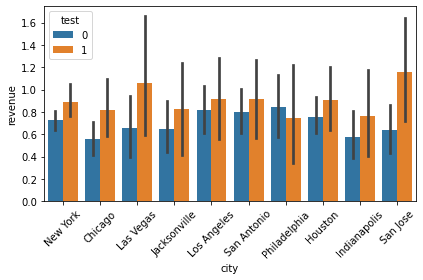

In [105]:
sns.barplot(x='city', y='revenue', hue='test', data=df_top_cities)
plt.xticks(rotation=45)
plt.show()

The test has won in terms of revenue.
We are losing approx 22% of customers though.
Larger revenue per user means company can invest more money in marketing channels

Insights:
- Friend referral is the best channel
- FB/Google ads have 2nd higher revenue per user than any other channel. SEO also has good revenue, and is free. Increasing traffic for SEO would lead to a good increase in revenue
- Mobile has more revenue per user than web. Focusing on mobile ads and traffic can make more money. 
- iOS is better than Android. iOS users could be less price sensitive than Android users. We could still investigate the differences in product between 2 platforms.

###  The VP of Product feels that the test has been running for too long and they should have been able to get statistically significant results in a shorter time. Do you agree with this? After how many days you would have stopped the test? Please, explain why.

In [106]:
conversion_rate_control = df.loc[df['test'] == 0]['converted'].mean()
p1_and_p2 = sms.proportion_effectsize(conversion_rate_control, conversion_rate_control*39/59)
sample_size = sms.NormalIndPower().solve_power(p1_and_p2, power=0.8, alpha=0.05)
print("The required sample size per group is ~", round(sample_size))

The required sample size per group is ~ 5549


In [118]:
df['week_of_year'] = pd.to_datetime(df['timestamp'].str.split(' ').str[0]).dt.strftime('%W')

In [119]:
df['week_of_year'].value_counts().sort_index()

week_of_year
09    24674
10    24257
11    24454
12    24433
13    24018
14    24860
15    24188
16    24253
17    24352
18    24528
19    24242
20    24042
21    24134
Name: count, dtype: int64

In [124]:
users_per_week = round(df['week_of_year'].value_counts().mean())
users_per_week

24341

If we ran the test on 50% of the users, we would be done in less than a week. However, it is a good practice to run the test for at least two weeks for weekly patterns. We can look at the minimum percentage of users that would need to be in test to get the required sample size in two weeks:

In [126]:
print("The percentage of traffic needed in test:", round(sample_size/(users_per_week*2)*100))

The percentage of traffic needed in test: 11
